In [1]:
from pathlib import Path
import numpy as np
import torch
import nibabel as nib
import re
import pyvista as pv
import nibabel as nib
import dill
import pandas as pd
from tqdm import tqdm
from nifti_utils import get_zooms, rescale_rot_components_with_diag

assert False, "Caution: pyvista plots require a machine with attached physical display or a display emulation (Xvfb package) - otherwise the kernel may die when generating renderings."

/var/folders/d1/jgnvf7q17hdbbt4mqz9gljph0000gn/T/ipykernel_51346/3869993245.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


AssertionError: Caution: pyvista plots require a machine with attached physical display or a display emulation (Xvfb package) - otherwise the kernel may die when generating renderings.

# Read params from files

In [11]:
def get_params(params_dir, view):
    df = None
    params_files = sorted(list(params_dir.glob(f'{view}_params*.pt*')))
    for fl in params_files:

        mt = re.match(r".*(train|val|test).*?([0-9]{1,5})\.pt", str(fl))
        phase, epoch = mt[1], int(mt[2])
        param_dict = torch.load(fl)
        affine_dict = param_dict[f'epx_{view}_theta_grid_affines']
        ids = list(zip(*sorted(affine_dict.items())))[0]
        affines = list(zip(*sorted(affine_dict.items())))[1]

        data = dict(
            view=view,
            sample=ids,
            epoch=epoch,
            grid_affine=[a.detach() for a in affine_dict.values()],
            phase=phase,
        )

        if df is None:
            df = pd.DataFrame(data)
        else:
            df = pd.concat([df, pd.DataFrame(data)], ignore_index=True)

    return df

In [12]:
params_dir = Path("/Users/christianweihsbach/code/visualize/20240201__16_29_09_sleek-design_fold-1_stage-opt_first/val")
sa_df = get_params(params_dir, 'sa')

params_dir = Path("/Users/christianweihsbach/code/visualize/20240201__16_29_09_sleek-design_fold-1_stage-opt_second/val")
hla_df = get_params(params_dir, 'hla')

df = pd.concat([sa_df, hla_df], ignore_index=True)

# Create mesh from shape voxels

In [13]:
import numpy as np
import torch
import h5py
# import pymeshfix as mf
import nibabel as nib
import pyvista as pv
from pathlib import Path
from skimage import measure
from matplotlib import pyplot as plt

In [14]:
nii_shape = nib.load("mr_train_1015_label.nii.gz")
shape_data = torch.as_tensor(nii_shape.get_fdata()).long()

In [15]:
shape_affine = torch.as_tensor(nii_shape.affine)
image_sample = nib.load("mr_train_1015_image.nii.gz").get_fdata()
SPACING = (1.,1.,1.)
STEP_SIZE = 2
CLASSES = ['background', 'MYO', 'LV', 'RV', 'LA', 'RA']

heart_data = {}
for class_idx, tag in enumerate(CLASSES):
    if class_idx == 0: continue

    sub_label = torch.nn.functional.one_hot(shape_data.long(), len(CLASSES))[:,:,:, class_idx]
    verts, faces, normals, values = measure.marching_cubes(sub_label.cpu().numpy(), spacing=SPACING, step_size=STEP_SIZE)
    mm_verts = torch.cat([torch.tensor(verts.copy()), torch.ones(len(verts),1)], dim=1)
    mm_verts = (shape_affine @ mm_verts.T.double()).T[:,:3]

    data = dict(
        verts=torch.as_tensor(mm_verts.numpy().copy()),
        faces=torch.as_tensor(faces.copy()),
        normals=torch.as_tensor(normals.copy()),
        values=torch.as_tensor(values.copy())
    )
    heart_data[tag] = data

In [16]:
sa_grid_affine = df.query('sample == "mr_1015" & view == "sa" & epoch == 79')['grid_affine'].values[0][None]
hla_grid_affine = df.query('sample == "mr_1015" & view == "hla" & epoch == 79')['grid_affine'].values[0][None]

sa_grid_affine = rescale_rot_components_with_diag(sa_grid_affine, 1/get_zooms(sa_grid_affine))
hla_grid_affine = rescale_rot_components_with_diag(hla_grid_affine, 1/get_zooms(hla_grid_affine))

In [17]:
from nifti_utils import nifti_grid_sample
FOV_MM = torch.tensor([192.,192.,192])
FOV_VOX = torch.tensor([128,128,128])

with torch.no_grad():
    sa_label, _, sa_affine = nifti_grid_sample(shape_data[None,None], shape_affine[None], None,
        fov_mm=FOV_MM, fov_vox=FOV_VOX, is_label=True,
        pre_grid_sample_affine=sa_grid_affine,
    )

    hla_label, _, hla_affine = nifti_grid_sample(shape_data[None,None], shape_affine[None], None,
        fov_mm=FOV_MM, fov_vox=FOV_VOX, is_label=True,
        pre_grid_sample_affine=hla_grid_affine,
    )

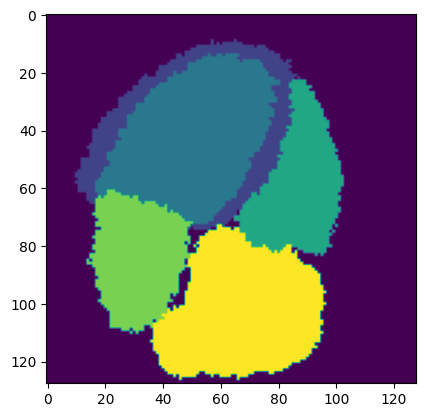

In [18]:
plt.imshow(sa_label.squeeze()[...,64].T)

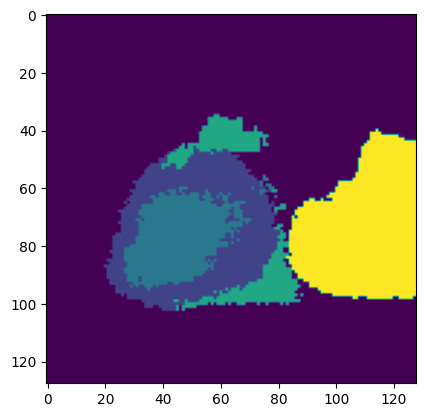

In [19]:
plt.imshow(hla_label[...,64].squeeze().T)

In [20]:
sa_normal = (sa_affine @ torch.tensor([0.,0.,1.,0.]).double())[0,:3]
sa_support = (sa_affine @ torch.tensor([64.,64.,64.,1.]).double())[0,:3]
print("Transformed SA", sa_normal, sa_support)

hla_normal = (hla_affine @ torch.tensor([0.,0.,1.,0.]).double())[0,:3]
hla_support =(hla_affine @ torch.tensor([64.,64.,64.,1.]).double())[0,:3]
print("Transformed HLA", hla_normal, hla_support)

Transformed SA tensor([-0.3122,  0.5539,  1.3586], dtype=torch.float64) tensor([-49.4600,  34.4056, -43.0727], dtype=torch.float64)
Transformed HLA tensor([-0.1595, -1.4251,  0.4401], dtype=torch.float64) tensor([-66.7411,  43.7925, -32.9002], dtype=torch.float64)


In [21]:
h_vertices = heart_data['MYO']['verts']
h_faces = heart_data['MYO']['faces']

for tag, data in heart_data.items():
    faces = data['faces']
    num_faces = faces.shape[0]
    num_points = torch.tensor([3]*num_faces).view(num_faces,1)
    data['pyvista_faces'] = torch.cat([num_points, faces], dim=1)

[[0.550287 0.161158 0.505719 0.8     ]
 [0.792427 0.244242 0.447543 1.      ]
 [0.967671 0.439703 0.35981  1.      ]
 [0.997351 0.719089 0.493755 1.      ]
 [0.987053 0.991438 0.749504 1.      ]]


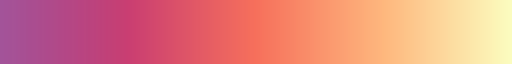

In [22]:
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
# https://coolors.co/b8336a-726da8-7d8cc4-a0d2db-c490d1

palette = [
    '#B8336A',
    '#726DA8',
    '#7D8CC4',
    '#A0D2DB',
    '#C490D1',
]
dark_palette = [
    '#4F172E',
    '#424064',
    '#485070',
    '#547378',
    '#73507C',
]

import matplotlib as mpl
magma_cut = mpl.colormaps['magma'](np.linspace(.4,1.,5))
magma_cut[0,-1] = .8
print(magma_cut)
cmap = LinearSegmentedColormap.from_list('magma_cut', magma_cut)
cmap

In [23]:
SHOW_FULL_MESH = True

SHOW_SA_PLANE = True
SHOW_SA_SLICE = True

SHOW_HLA_PLANE = True
SHOW_HLA_SLICE = True

ORIENTATION = 'custom'

assert ORIENTATION in ['custom', 'HLA', 'SA']

plotter = pv.Plotter(
    lighting='three lights'
)
plotter.background_color = "white"

cpos = 'iso'
sa_plane = pv.Plane(center=sa_support.tolist(), direction=sa_normal.tolist(), i_size=240, j_size=240, i_resolution=1, j_resolution=1)
sa_plane.point_data.clear()
sa_edges = sa_plane.extract_feature_edges(boundary_edges=True, feature_edges=False, manifold_edges=False)

hla_plane = pv.Plane(center=hla_support.tolist(), direction=hla_normal.tolist(), i_size=240, j_size=240, i_resolution=1, j_resolution=1)
hla_plane.point_data.clear()
hla_edges = hla_plane.extract_feature_edges(boundary_edges=True, feature_edges=False, manifold_edges=False)

full_mesh = []

# Prepare meshes
for idx, (tag, data) in enumerate(heart_data.items()):
    surf = pv.PolyData(data['verts'].numpy(), data['pyvista_faces'].view(-1).numpy())
    scalars=np.array([idx]*data['verts'].shape[0])
    surf.point_data.set_scalars(scalars, 'scalars')
    # full_mesh.append(surf)
    smooth = surf.smooth_taubin(n_iter=100, pass_band=0.3)
    full_mesh.append(smooth)

block = pv.MultiBlock(full_mesh)
full_mesh = block.combine(merge_points=False)

sa_slice = full_mesh.slice(normal=sa_normal.tolist(), origin=sa_support.tolist())
hla_slice = full_mesh.slice(normal=hla_normal.tolist(), origin=hla_support.tolist())

if SHOW_FULL_MESH:
    plotter.add_mesh(full_mesh, name='all', cmap=cmap, line_width=2, show_scalar_bar=False, smooth_shading=True)

if SHOW_SA_SLICE:
    plotter.add_mesh(sa_slice, name='sa_slice', cmap=cmap, line_width=2, show_scalar_bar=False)

if SHOW_SA_PLANE:
    plotter.add_mesh(sa_plane, color=palette[idx],  opacity=0.3, show_edges=False, line_width=2)
    plotter.add_mesh(sa_edges, color=dark_palette[idx], line_width=1)

if SHOW_HLA_SLICE:
    plotter.add_mesh(hla_slice, name='hla_slice', cmap=cmap, line_width=2, show_scalar_bar=False)

if SHOW_HLA_PLANE:
    plotter.add_mesh(hla_plane, color=palette[idx],  opacity=0.3, show_edges=False, line_width=2)
    plotter.add_mesh(hla_edges, color=dark_palette[idx], line_width=1)

plotter.view_isometric()
plotter.enable_parallel_projection()


if ORIENTATION == 'HLA':
    plotter.camera.position = (hla_support+hla_normal).tolist()
    plotter.camera.focal_point = hla_support.tolist()
    plotter.camera.up = (0.0, 1.0, 0.0)
    CPOS = None
    plotter.camera.zoom(1.0)


elif ORIENTATION == 'SA':
    plotter.camera.position = (sa_support+sa_normal).tolist()
    plotter.camera.focal_point = sa_support.tolist()
    plotter.camera.up = (0.0, 1.0, 0.0)
    CPOS = None
    plotter.camera.zoom(1.0)
else:
    CPOS = [(-197.83877598229623, 115.84841835647464, 308.3400332147713),
 (-60.352217898947785, -8.401068746929688, -10.565500454759558),
 (0.8644550419037054, -0.21263129938713254, 0.45552761831551225)]
    plotter.camera.zoom(.8)


plotter.show(
    window_size=[1200,1200],
    # jupyter_backend='static',
    cpos=CPOS,
    screenshot='optimized.png'
)

Widget(value='<iframe src="http://localhost:57925/index.html?ui=P_0x143656c00_0&reconnect=auto" class="pyvista…

 JS Error => error: Uncaught TypeError: Cannot mix BigInt and other types, use explicit conversions


In [28]:
plotter.camera_position

[(-67.9261474609375, -585.4993896484375, -289.9613952636719),
 (-74.73036193847656, 5.15444803237915, 9.02255916595459),
 (0.7768819506757739, -0.27721852687290943, 0.5653355844740523)]

In [29]:
import numpy as np
import math

def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = axis / axis.dot(axis).sqrt()
    a = (theta / 2.0).cos()
    b, c, d = -axis * (theta / 2.0).sin()
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

In [30]:
SHOW_FULL_MESH = True

PLANE_SIZE_MM = 224

SHOW_SA_PLANE = True
SHOW_SA_SLICE = True

SHOW_HLA_PLANE = True
SHOW_HLA_SLICE = True

ORIENTATION = 'custom'
assert ORIENTATION in ['custom', 'HLA', 'SA']

GIF_NAME = 'anim.gif'

plotter = pv.Plotter(
    lighting='three lights'
)
plotter.window_size=[1200,1200]
plotter.background_color = "white"
plotter.view_isometric()
plotter.enable_parallel_projection()

if ORIENTATION == 'HLA':
    plotter.camera.position = (hla_support+hla_normal).tolist()
    plotter.camera.focal_point = hla_support.tolist()
    plotter.camera.up = (0.0, 1.0, 0.0)
    CPOS = None
    plotter.camera.zoom(1.0)
elif ORIENTATION == 'SA':
    plotter.camera.position = (sa_support+sa_normal).tolist()
    plotter.camera.focal_point = sa_support.tolist()
    plotter.camera.up = (0.0, 1.0, 0.0)
    CPOS = None
    plotter.camera.zoom(.8)
else:
    CPOS = torch.tensor([
        (209.2207705021671, -275.7904587797502, -518.9463886550571),
        (-74.73036258375254, 5.154448101887414, 9.022559632140428),
        (0.7768819378130275, -0.2772185334716578, 0.565335598914219)]
    )
    # plotter.camera_position = CPOS
    plotter.camera.position = CPOS[0].numpy()
    plotter.camera.focal_point = CPOS[1].numpy()
    plotter.camera.up = CPOS[2].numpy()
    plotter.camera.zoom(.003)

def get_rotated_cpos_closure(camera):
    up = torch.as_tensor(camera.up)
    focal_point = torch.as_tensor(camera.focal_point)
    position = torch.as_tensor(camera.position)

    def set_rotated_cpos(deg_angle):
        diff = position - focal_point
        rot_mat = torch.as_tensor(rotation_matrix(up, deg_angle/180*np.pi))

        new_diff = rot_mat @ diff
        new_position = new_diff + focal_point
        camera.position = new_position.numpy()

    return set_rotated_cpos


set_rotated_cpos = get_rotated_cpos_closure(plotter.camera)

plotter.open_gif(GIF_NAME)

full_mesh = []

# Prepare meshes
for idx, (tag, data) in enumerate(heart_data.items()):
    surf = pv.PolyData(data['verts'].numpy(), data['pyvista_faces'].view(-1).numpy())
    scalars=np.array([idx]*data['verts'].shape[0])
    surf.point_data.set_scalars(scalars, 'scalars')
    # full_mesh.append(surf)
    smooth = surf.smooth_taubin(n_iter=100, pass_band=0.3)
    full_mesh.append(smooth)

block = pv.MultiBlock(full_mesh)
full_mesh = block.combine(merge_points=False)

if SHOW_FULL_MESH:
    plotter.add_mesh(full_mesh, name='all', cmap=cmap, line_width=2, show_scalar_bar=False, smooth_shading=True)

smps = df.query('sample == "mr_1015"')#.sort_values('epoch', ascending=True)

sa_slice_actors = []
hla_slice_actors = []

for frame_idx, sample_idx in enumerate(tqdm(smps.index)):
    set_rotated_cpos(torch.tensor(frame_idx*2.))

    smp = smps.loc[sample_idx]

    optimized_mat = smp['grid_affine'][None]
    optimized_mat = rescale_rot_components_with_diag(optimized_mat, 1/get_zooms(optimized_mat))

    with torch.no_grad():
        _, _, optimized_nii_affine = nifti_grid_sample(
            shape_data.unsqueeze(0).unsqueeze(0), shape_affine.unsqueeze(0), None,
            fov_mm=FOV_MM, fov_vox=FOV_VOX, is_label=True,
            pre_grid_sample_affine=optimized_mat,
        )

    if smp['view'] == 'sa':
        while len(sa_slice_actors):
            actor = sa_slice_actors.pop()
            plotter.remove_actor(actor)

        # SA slicing
        sa_normal = (optimized_nii_affine @ torch.tensor([0.,0.,1.,0.]).double())[0,:3]
        sa_support = (optimized_nii_affine @ torch.tensor([64.,64.,64.,1.]).double())[0,:3]

        sa_plane = pv.Plane(center=sa_support.tolist(), direction=sa_normal.tolist(), i_size=200, j_size=200, i_resolution=1, j_resolution=1)
        sa_plane.point_data.clear()
        sa_edges = sa_plane.extract_feature_edges(boundary_edges=True, feature_edges=False, manifold_edges=False)
        sa_slice = full_mesh.slice(normal=sa_normal.tolist(), origin=sa_support.tolist())

        if SHOW_SA_SLICE:
            slc_actor = plotter.add_mesh(sa_slice, name='sa_slice', cmap=cmap, line_width=2, show_scalar_bar=False)
            sa_slice_actors.append(slc_actor)

        if SHOW_SA_PLANE:
            slc_actor = plotter.add_mesh(sa_plane, color=cmap(.2),  opacity=0.3, show_edges=False, line_width=2)
            sa_slice_actors.append(slc_actor)
            slc_actor = plotter.add_mesh(sa_edges, color=cmap(0.), line_width=1)
            sa_slice_actors.append(slc_actor)

    if smp['view'] == 'hla':
        while len(hla_slice_actors):
            actor = hla_slice_actors.pop()
            plotter.remove_actor(actor)

        # HLA slicing
        hla_normal = (optimized_nii_affine @ torch.tensor([0.,0.,1.,0.]).double())[0,:3]
        hla_support = (optimized_nii_affine @ torch.tensor([64.,64.,64.,1.]).double())[0,:3]
        hla_plane = pv.Plane(center=hla_support.tolist(), direction=hla_normal.tolist(), i_size=200, j_size=200, i_resolution=1, j_resolution=1)
        hla_plane.point_data.clear()
        hla_edges = hla_plane.extract_feature_edges(boundary_edges=True, feature_edges=False, manifold_edges=False)
        hla_slice = full_mesh.slice(normal=hla_normal.tolist(), origin=hla_support.tolist())

        if SHOW_HLA_SLICE:
            slc_actor = plotter.add_mesh(hla_slice, name='hla_slice', cmap=cmap, line_width=2, show_scalar_bar=False)
            hla_slice_actors.append(slc_actor)

        if SHOW_HLA_PLANE:
            slc_actor = plotter.add_mesh(hla_plane, color=cmap(.2),  opacity=0.3, show_edges=False, line_width=2)
            hla_slice_actors.append(slc_actor)
            slc_actor = plotter.add_mesh(hla_edges, color=cmap(.0), line_width=1)
            hla_slice_actors.append(slc_actor)

    # plotter.show()
    # break
    plotter.write_frame()


# Closes and finalizes movie
plotter.close()

100%|██████████| 160/160 [00:13<00:00, 11.71it/s]
